In [1]:
import pandas as pd
import datetime

In [35]:
month_data = pd.read_csv('产量月度数据.csv')

In [36]:
month_data = month_data.T
month_data.columns = month_data.iloc[0,:].values

In [39]:
month_data.drop('指标',axis=0,inplace=True)

In [55]:
month_data.index = pd.to_datetime([datetime.datetime.strptime(i,'%Y年%m月') for i in month_data.index])

In [66]:
month_data = month_data.reset_index().sort_values('index').set_index('index')

In [73]:
electronic = month_data.iloc[:,1].fillna(method = 'bfill')
gas = month_data.iloc[:,4].fillna(method = 'bfill')
carbon = month_data.iloc[:,8].fillna(method = 'bfill')
olil = month_data.iloc[:,12].fillna(method = 'bfill')

In [308]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'checkpoint.pth')
        self.val_loss_min = val_loss


In [242]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [329]:
training_set = electronic.values.reshape(-1,1)

In [369]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 12
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.GRU = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, h_out= self.GRU(x, h_0)
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out
class BiLSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(BiLSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,bidirectional=True)
        
        self.fc = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            2*self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            2*self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, 2*self.hidden_size)
        
        out = self.fc(h_out)
        
        return out
class Transformer(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(Transformer, self).__init__()
        
        self.Transformer = nn.Transformer(d_model=64,nhead = 2,num_encoder_layers =1 ,num_decoder_layers = 2,dim_feedforward = 1)
        
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        
        x= self.Transformer(x, x)
        
        
        out = self.fc(x)
        
        return out

In [370]:
num_epochs = 4000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

#lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
model = BiLSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.07502
Epoch: 100, loss: 0.01287
Epoch: 200, loss: 0.01229
Epoch: 300, loss: 0.01196
Epoch: 400, loss: 0.00950
Epoch: 500, loss: 0.00778
Epoch: 600, loss: 0.00684
Epoch: 700, loss: 0.00609
Epoch: 800, loss: 0.00563
Epoch: 900, loss: 0.00546
Epoch: 1000, loss: 0.00527
Epoch: 1100, loss: 0.00510
Epoch: 1200, loss: 0.00518
Epoch: 1300, loss: 0.00494
Epoch: 1400, loss: 0.00488
Epoch: 1500, loss: 0.00509
Epoch: 1600, loss: 0.00478
Epoch: 1700, loss: 0.00475
Epoch: 1800, loss: 0.00465
Epoch: 1900, loss: 0.00466
Epoch: 2000, loss: 0.00458
Epoch: 2100, loss: 0.00454
Epoch: 2200, loss: 0.00449
Epoch: 2300, loss: 0.00501
Epoch: 2400, loss: 0.00441
Epoch: 2500, loss: 0.00438
Epoch: 2600, loss: 0.00429
Epoch: 2700, loss: 0.00418
Epoch: 2800, loss: 0.00409
Epoch: 2900, loss: 0.00403
Epoch: 3000, loss: 0.00407
Epoch: 3100, loss: 0.00379
Epoch: 3200, loss: 0.00362
Epoch: 3300, loss: 0.00358
Epoch: 3400, loss: 0.00350
Epoch: 3500, loss: 0.00393
Epoch: 3600, loss: 0.00342
Epoch: 3700, 

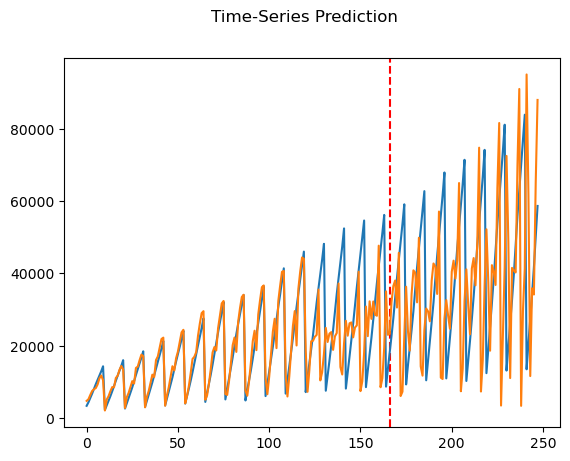

In [371]:
import matplotlib.pyplot as plt
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [361]:
transformer_model = nn.Transformer(d_model=64,nhead = 2,num_encoder_layers =1 ,num_decoder_layers = 2,dim_feedforward = 1)
src = torch.rand((3, 32, 64))
tgt = torch.rand((20, 32, 64))
out = transformer_model(src, tgt)

In [362]:
out.shape

torch.Size([20, 32, 64])